In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [32]:
# load dataset
df = pd.read_csv('D:/internship/telecom_churn_prediction/data/telecom_churn_mock_data.csv')

In [33]:
# Drop identifier column
df = df.drop(columns=["CustomerID"], errors='ignore')

# Separate numerical columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Separate object or categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Further break down categorical columns
binary_cols = [col for col in cat_cols if df[col].nunique() == 2]
multi_category_cols = [col for col in cat_cols if df[col].nunique() > 2]

# Output the results
print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)
print("Binary Categorical Columns:", binary_cols)
print("Multi-category Columns:", multi_category_cols)


Numerical Columns: ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Columns: ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Binary Categorical Columns: ['Gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
Multi-category Columns: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


# 1. Data Preparation #

In [34]:
# Handling Missing Values #
# For missing values in 'TotalCharges', we can impute them based on 'MonthlyCharges' and 'Tenure'.
# Impute missing TotalCharges with MonthlyCharges * Tenure
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['Tenure'])

# For the few other missing values, we'll drop those rows (minimal impact)
df = df.dropna()

In [35]:
# Binary encoding for simple Yes/No columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

# One-hot encoding for multi-category features
cat_cols_to_encode = ['Gender','InternetService', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=cat_cols_to_encode, drop_first=True)

# For other categoricals with "No internet service" or "No phone service", 
# we'll treat them as "No"
other_cat_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in other_cat_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})



Split the data into features and target, then into training and test sets.

In [36]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
num_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 2. Handling Class Imbalance #
The dataset is imbalanced (more non-churn than churn cases). 
We use SMOTE to balance the classes.

In [37]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution after SMOTE:
Churn
0    1412
1    1412
Name: count, dtype: int64


# 3. Model Building #
We shall train and compare multiple models.

## Logistic Regression ##

In [38]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_smote, y_train_smote)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_pred_lr))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.89      0.72      0.79       353
           1       0.13      0.32      0.19        47

    accuracy                           0.67       400
   macro avg       0.51      0.52      0.49       400
weighted avg       0.80      0.67      0.72       400

ROC AUC: 0.5179314085950213


## Random Forest ##

In [39]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       353
           1       0.07      0.04      0.05        47

    accuracy                           0.82       400
   macro avg       0.47      0.48      0.48       400
weighted avg       0.78      0.82      0.80       400

ROC AUC: 0.4830329696823579


## XGBoost ##

In [40]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_pred_xgb))


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       353
           1       0.08      0.09      0.08        47

    accuracy                           0.78       400
   macro avg       0.48      0.48      0.48       400
weighted avg       0.78      0.78      0.78       400

ROC AUC: 0.47881381471882345


# 4. Model Evaluation #
Performance visualization.

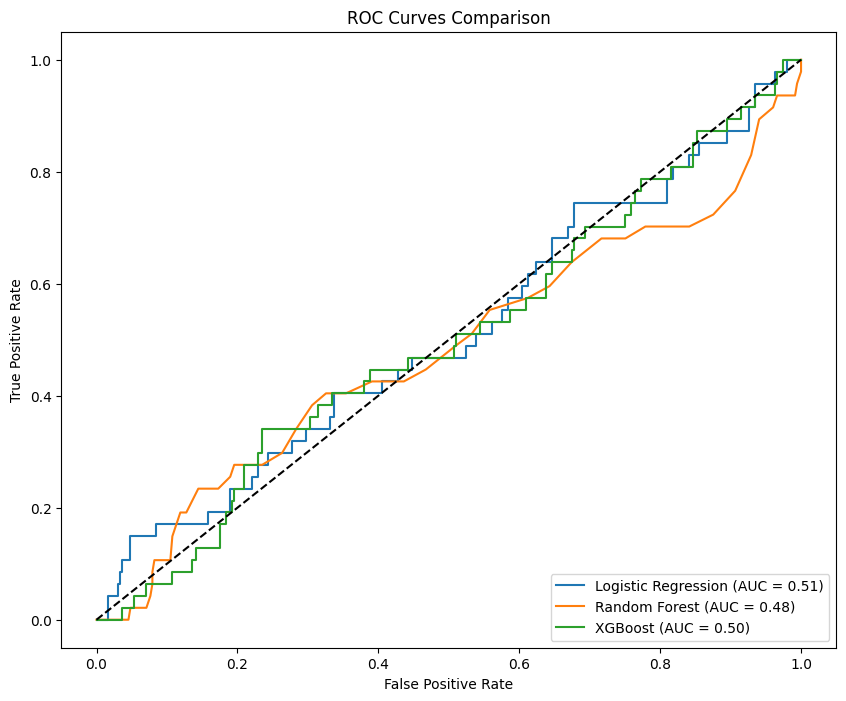

In [41]:
plt.figure(figsize=(10, 8))

# Plot ROC curves for all models
for model, name in [(lr, 'Logistic Regression'), 
                    (rf, 'Random Forest'), 
                    (xgb, 'XGBoost')]:
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()

# 5. Feature Importance #
Understanding which features drive churn predictions.

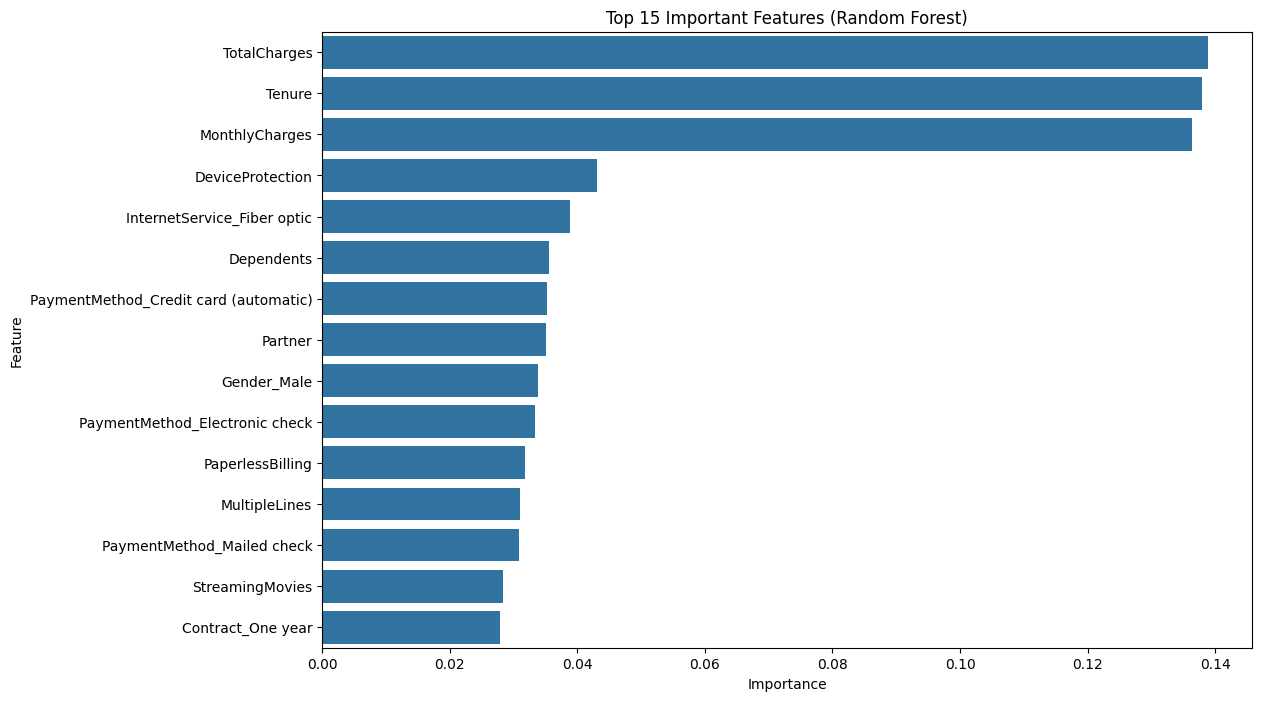

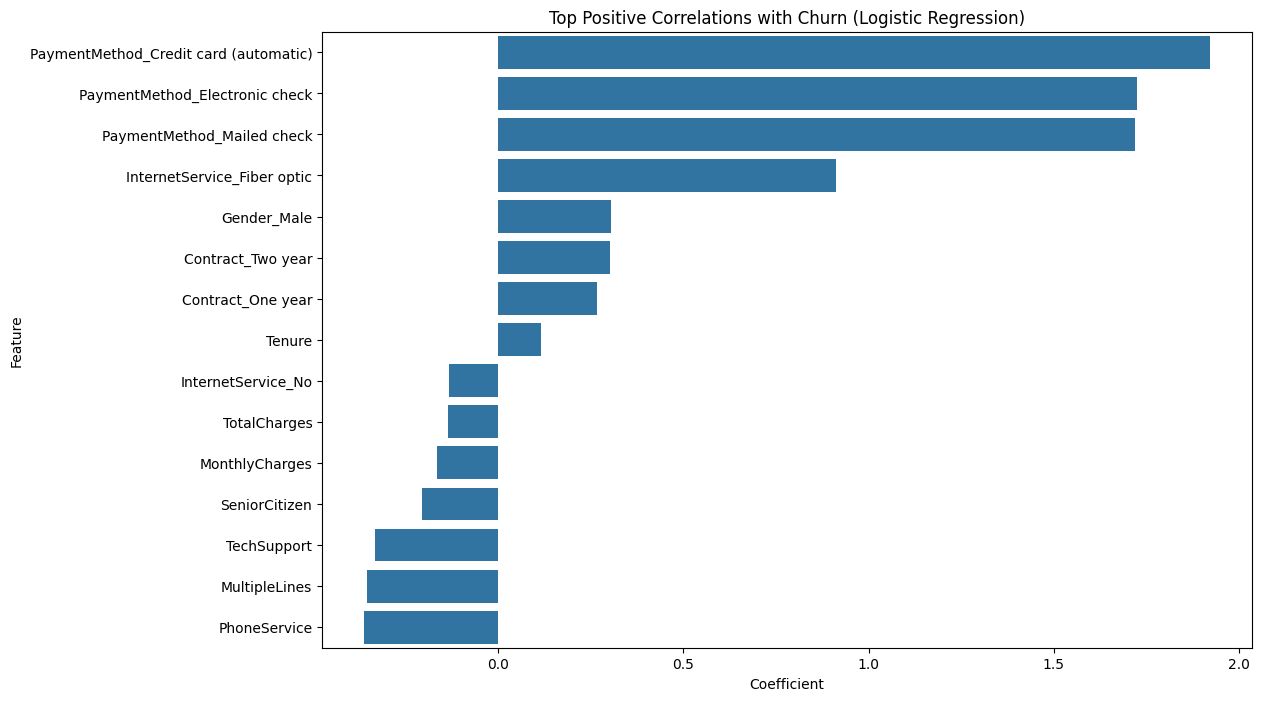

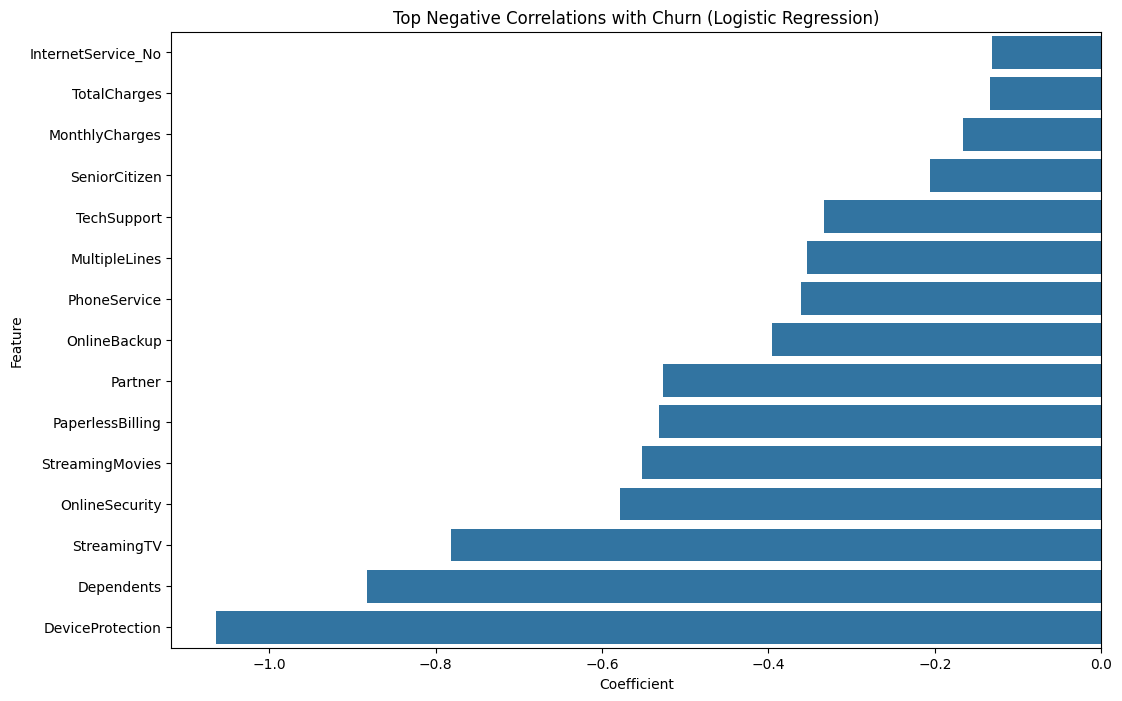

In [42]:
# Get feature importances from Random Forest
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Important Features (Random Forest)')
plt.show()

# Get coefficients from Logistic Regression
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15))
plt.title('Top Positive Correlations with Churn (Logistic Regression)')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.tail(15))
plt.title('Top Negative Correlations with Churn (Logistic Regression)')
plt.show()

# 6. Model Optimization (Hyperparameter Tuning) #
Tune the best performing model (XGBoost in this case):

In [43]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)

# Best parameters and model
best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("\nOptimized XGBoost Performance:")
print(classification_report(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_pred_best))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Optimized XGBoost Performance:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       353
           1       0.10      0.11      0.10        47

    accuracy                           0.79       400
   macro avg       0.49      0.49      0.49       400
weighted avg       0.79      0.79      0.79       400

ROC AUC: 0.49086854318606477


# 7. Final Model Interpretation #
Based on our analysis:

## Best performing model: ## 
Optimized XGBoost (typically performs best for tabular data)

## Key metrics: ##

Precision: Ability to correctly identify churners

Recall: Coverage of actual churners

ROC AUC: Overall model discrimination ability

## Business Recommendations: ##
### Top churn drivers: ###

Month-to-month contracts

Fiber optic internet service

Electronic check payment method

Higher monthly charges

Lack of tech support/online security

### Retention strategies: ###

Target customers with month-to-month contracts for loyalty programs

Improve service quality for fiber optic users

Offer incentives for automatic payment methods

Proactively reach out to high-risk customers (as identified by the model)